## SRCNN

This notebook is an implementation of a SRCNN

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
tf.__version__

'2.15.0'

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam

In [6]:
import cv2
import numpy as np

In [7]:
import matplotlib.pyplot as plt

### SRCNN Dataset Preprocessing

In [8]:
ds_train = tfds.load('div2k/bicubic_x2', split='train')

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.BYO9BO_2.0.0/div2k-train.tfrecord*...:   0%|  …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x2/incomplete.BYO9BO_2.0.0/div2k-validation.tfrecord*...:   …

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x2/2.0.0. Subsequent calls will reuse this data.


In [9]:
def train_low(ds_train, size, scale):
    data = []
    for example in ds_train:
        hr_image = example['hr'].numpy()  # Extract high-resolution image

        # convert from TensorFlow tensor to numpy array and from YCbCr to BGR
        hr_image_bgr = cv2.cvtColor(hr_image, cv2.COLOR_YCrCb2BGR)

        # downsample and upsample using bicubic interpolation
        img = cv2.resize(hr_image_bgr, (size, size), cv2.INTER_CUBIC)
        img = cv2.resize(img, (size * scale, size * scale), cv2.INTER_CUBIC)

        # convert back to YCrCb and extract luma (Y) channel
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255

        data.append(img)

    data = np.array(data)

    return data

In [10]:
y_train_low = train_low(ds_train, 128, 2)

In [11]:
def train_high(ds_train, size):
    data = []
    for example in ds_train:
        hr_image = example['hr'].numpy()  # extract high-resolution image

        # convert from TensorFlow tensor to numpy array and from YCbCr to BGR
        hr_image_bgr = cv2.cvtColor(hr_image, cv2.COLOR_YCrCb2BGR)

        img = cv2.resize(hr_image_bgr, (size, size))

        # convert back to YCrCb and extract luma (Y) channel
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img = img[:, :, 0].astype(float) / 255

        data.append(img)

    data = np.array(data)

    return data

In [12]:
X_train_high = train_high(ds_train, 256)

In [13]:
X_train_high.shape

(800, 256, 256)

### SRCNN architecture

In [14]:
# define the SRCNN model
def model():

    # define model type
    SRCNN = Sequential()

    # add model layers  #    (1392, 2040, 3)
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True, input_shape=(None,None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='same', use_bias=True))

    # define optimizer
    adam = Adam(lr=0.0003)

    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])

    return SRCNN

In [15]:
srcnn = model()
srcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   10496     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 85889 (335.50 KB)
Trainable params: 85889 (335.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Text(0.5, 1.0, 'high resolution ')

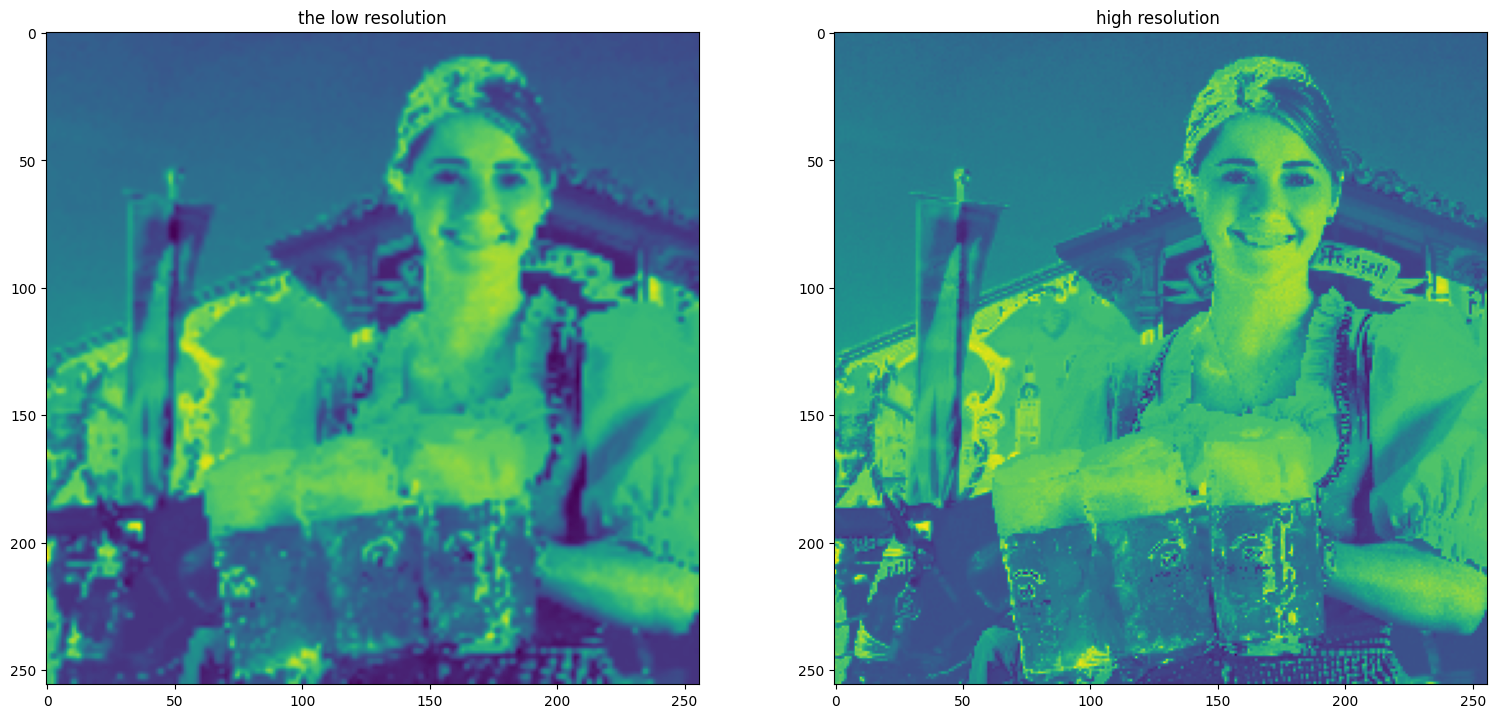

In [16]:
plt.figure(figsize = (100, 100))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(y_train_low[5])
plt.title("the low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(X_train_high[5])
plt.title("high resolution ")

In [17]:
low= np.zeros((y_train_low.shape[0], y_train_low.shape[1], y_train_low.shape[2], 1), dtype=float)
low[:, :, :, 0]=y_train_low[:, :, :].astype(float)
low.shape

(800, 256, 256, 1)

In [18]:
high= np.zeros((X_train_high.shape[0], X_train_high.shape[1], X_train_high.shape[2], 1), dtype=float)
high[:, :, :, 0]=X_train_high[:, :, :].astype(float)
high.shape

(800, 256, 256, 1)

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [20]:
history=srcnn.fit( low, high, batch_size=10, validation_split=0.2, shuffle=True, epochs=100, callbacks=[callback])

Epoch 1/100
64/64 [==============================] - 15s 104ms/step - loss: 0.0182 - accuracy: 3.0994e-07 - val_loss: 0.0062 - val_accuracy: 9.5367e-08
Epoch 2/100
64/64 [==============================] - 6s 97ms/step - loss: 0.0058 - accuracy: 3.3379e-07 - val_loss: 0.0051 - val_accuracy: 9.5367e-08
Epoch 3/100
64/64 [==============================] - 6s 97ms/step - loss: 0.0051 - accuracy: 3.3379e-07 - val_loss: 0.0048 - val_accuracy: 9.5367e-08
Epoch 4/100
64/64 [==============================] - 6s 98ms/step - loss: 0.0050 - accuracy: 3.3379e-07 - val_loss: 0.0048 - val_accuracy: 9.5367e-08
Epoch 5/100
64/64 [==============================] - 6s 99ms/step - loss: 0.0050 - accuracy: 3.3379e-07 - val_loss: 0.0054 - val_accuracy: 9.5367e-08
Epoch 6/100
64/64 [==============================] - 6s 96ms/step - loss: 0.0050 - accuracy: 3.3379e-07 - val_loss: 0.0047 - val_accuracy: 9.5367e-08
Epoch 7/100
64/64 [==============================] - 6s 97ms/step - loss: 0.0049 - accuracy: 3.337

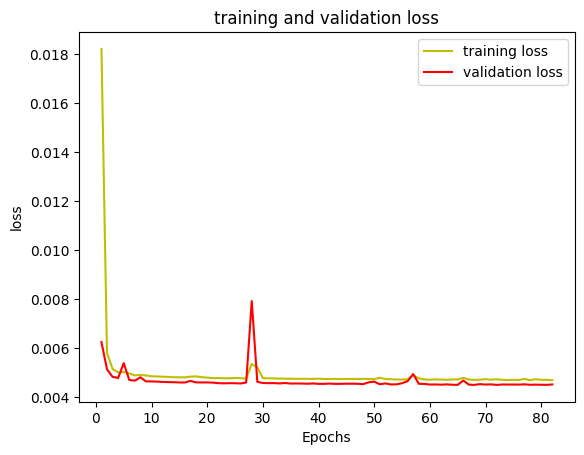

In [21]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

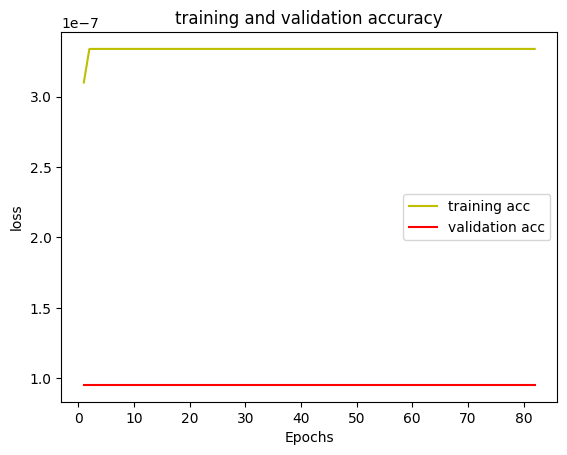

In [22]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [23]:
srcnn.save('srcnn_model_2x.tf')

### Testing SRCNN

In [24]:
import time

In [25]:
srcnn_model = tf.keras.models.load_model("srcnn_model_2x.tf")

In [26]:
srcnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   10496     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 85889 (335.50 KB)
Trainable params: 85889 (335.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
upscale_factor=2
fullimg = cv2.imread("halfwoman.jpg", 3)  # input shape

print("start image", fullimg.shape)
width = fullimg.shape[0]
height = fullimg.shape[1]
img = fullimg

floatimg = img.astype(np.float32) / 255.0
imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
imgY = imgYCbCr[:, :, 0]
imgY = np.expand_dims(cv2.resize(imgYCbCr[:, :, 0], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                    axis=2)
print("imgY",imgY.shape)

t0= time.time()
LR_input_ = imgY.reshape(1, imgY.shape[0], imgY.shape[1], 1)
t1 = time.time() - t0
print("Time elapsed: ", t1)
Y = srcnn_model.predict([LR_input_])[0]
Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                    axis=2)
Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                    axis=2)
HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)

HR_image = ((cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)) * 255.0).clip(min=0, max=255)
HR_image = (HR_image).astype(np.uint8)
print(HR_image.shape)
cv2.imwrite("srcnnquarwoman.png", HR_image) # used to save an image to any storage device

start image (172, 114, 3)
imgY (344, 228, 1)
Time elapsed:  0.0001773834228515625
1/1 [==============================] - 0s 484ms/step
(344, 228, 3)


True

Text(0.5, 1.0, ' Model ')

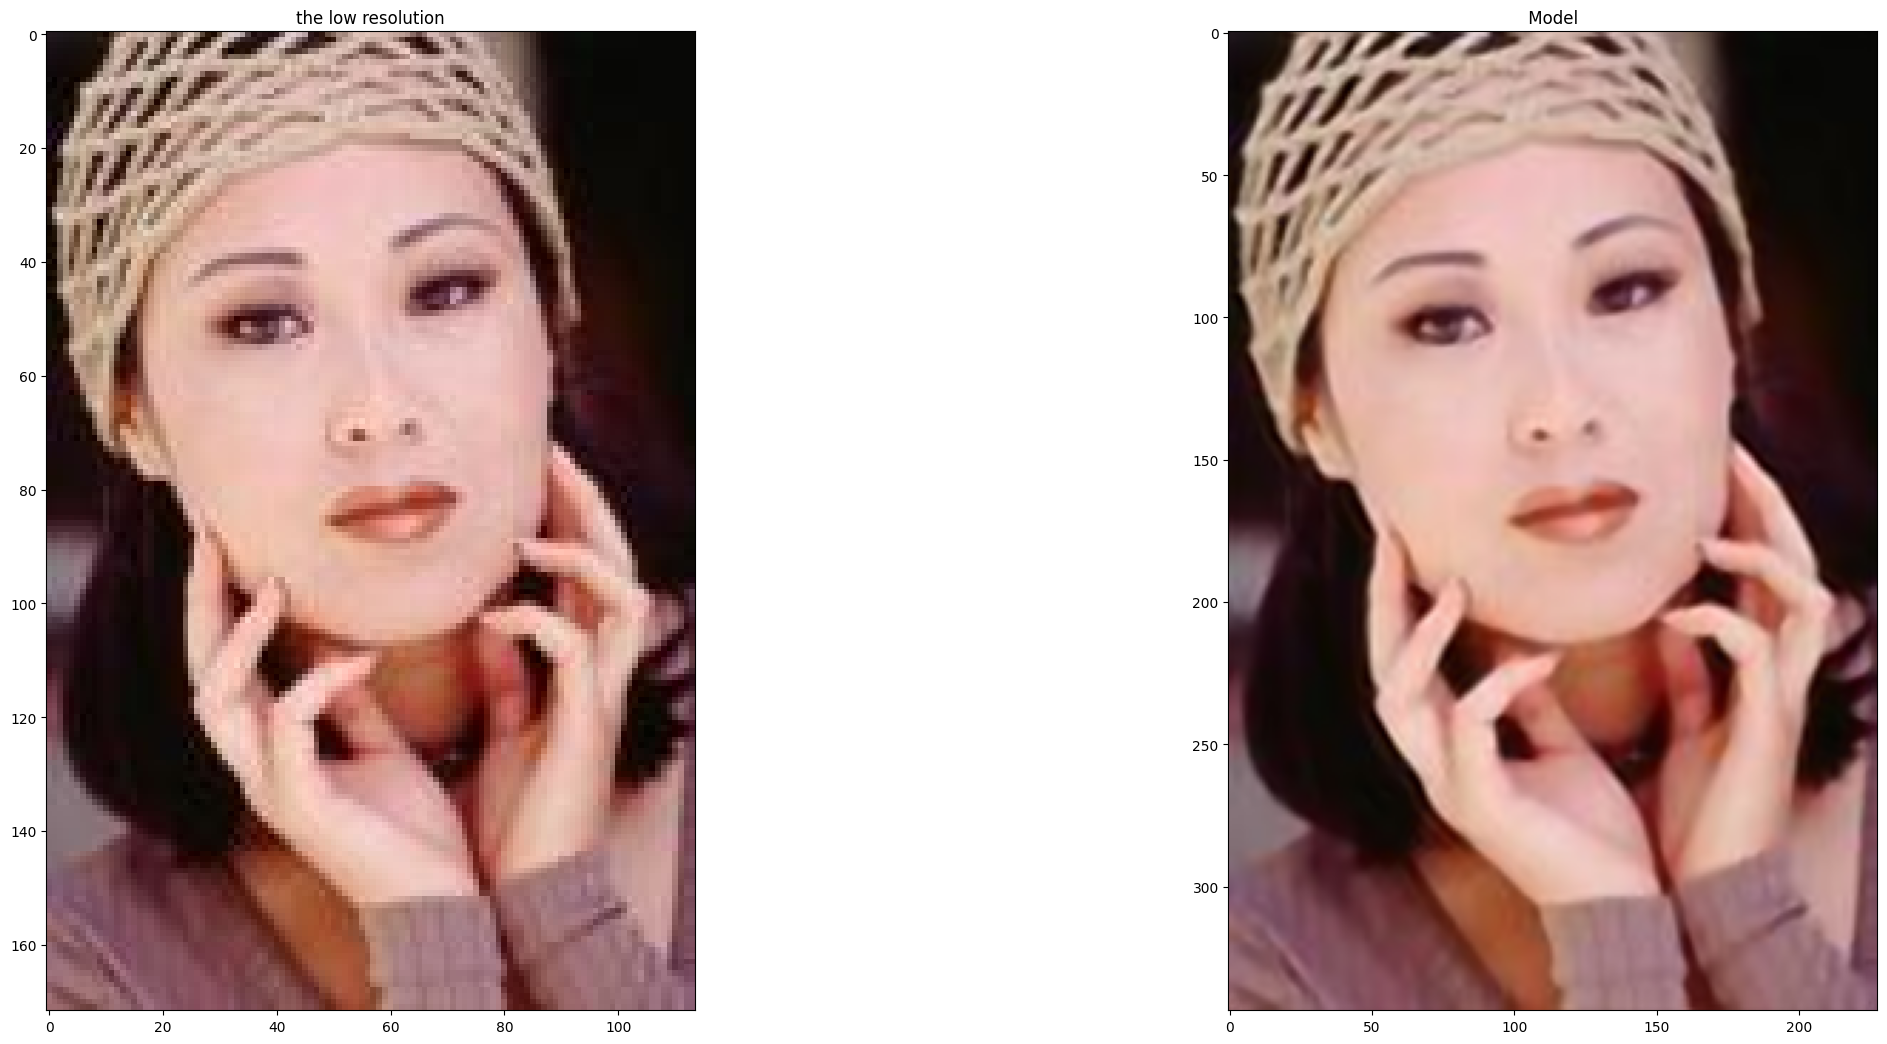

In [29]:
from matplotlib import pyplot as plt
plt.figure(figsize = (150, 150))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(cv2.cvtColor(fullimg, cv2.COLOR_BGR2RGB))
plt.title("the low resolution")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(cv2.cvtColor(HR_image, cv2.COLOR_BGR2RGB))
plt.title(" Model ")